In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import glob 
import os 
import pickle 
from scipy.spatial.transform import Rotation as R 
from simpleicp import PointCloud, SimpleICP
from scipy.spatial import KDTree 

In [2]:
# convert pose to transformation matrix 
def pose2transform(pose):
    if pose.ndim == 1:
        if pose.shape[0] == 6: 
            T = np.eye(4) 
            T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=True).as_matrix() 
            T[:3, 3] = pose[:3] 
            return T 
        elif pose.shape[0] == 7: 
            T = np.eye(4) 
            T[:3, :3] = R.from_quat(pose[3:], scalar_first=True).as_matrix() 
            T[:3, 3] = pose[:3] 
            return T 
    else: 
        if pose.shape[1] == 6: 
            T = np.zeros((pose.shape[0], 4, 4)) 
            for i in range(pose.shape[0]): 
                T[i, :3, :3] = R.from_euler('xyz', pose[i, 3:], degrees=True).as_matrix() 
                T[i, :3, 3] = pose[i, :3] 
            T[:, 3, 3] = 1 
            return T 
        elif pose.shape[1] == 7: 
            T = np.zeros((pose.shape[0], 4, 4)) 
            for i in range(pose.shape[0]): 
                T[i, :3, :3] = R.from_quat(pose[i, 3:], scalar_first=True).as_matrix() 
                T[i, :3, 3] = pose[i, :3] 
            T[:, 3, 3] = 1 
            return T 
        
def poses7D2poses6D(poses):
    if poses.ndim == 1: 
        poses6D = np.zeros(6) 
        poses6D[:3] = poses[:3] 
        poses6D[3:] = R.from_quat(poses[3:], scalar_first=True).as_euler('xyz', degrees=True) 
        return poses6D
    else:  
        poses6D = np.zeros((poses.shape[0], 6)) 
        for i in range(poses.shape[0]): 
            poses6D[i, :3] = poses[i, :3] 
            poses6D[i, 3:] = R.from_quat(poses[i, 3:], scalar_first=True).as_euler('xyz', degrees=True) 
        return poses6D 

# convert transformation matrix to pose 
def transform2pose(T):
    pose = np.zeros(7) 
    pose[:3] = T[:3, 3] 
    pose[3:] = R.from_matrix(T[:3, :3]).as_quat(scalar_first=True) 
    return pose 

def pose6D2transform(pose):
    T = np.eye(4) 
    T[:3, :3] = R.from_euler('xyz', pose[3:], degrees=True).as_matrix() 
    T[:3, 3] = pose[:3] 
    return T 

def transform2pose6D(T):   
    pose = np.zeros(6) 
    pose[:3] = T[:3, 3] 
    pose[3:] = R.from_matrix(T[:3, :3]).as_euler('xyz', degrees=True) 
    return pose 

# transform array of poses by a given pose 
def transform_poses(poses, delta_pose): 
    T_delta = pose2transform(delta_pose) 
    transformed_poses = np.zeros_like(poses) 
    for i in range(poses.shape[0]):
        transformed_poses[i] = transform2pose(np.linalg.inv(T_delta) @ pose2transform(poses[i])) # T_P0Pi = T_P0H @ T_HPi  
    return transformed_poses 

def transform_poses6D(poses, delta_pose): 
    T_delta = pose6D2transform(delta_pose) 
    transformed_poses = np.zeros_like(poses) 
    for i in range(poses.shape[0]):
        transformed_poses[i] = transform2pose6D(np.linalg.inv(T_delta) @ pose6D2transform(poses[i])) # T_P0Pi = T_P0H @ T_HPi  
    return transformed_poses 

def nearest_neighbor(P_t, P_s): 
    kdtree = KDTree(P_t) 
    dist, idx = kdtree.query(P_s) 
    correspondences = P_t[idx] 
    return correspondences 

def compute_delta_pose(P_s, P_t): 
    # crude estimate of transformation using mean, technically not the best way to do this since 6D pose is not smooth 
    if P_s.ndim == 1: 
        mean_pose_s = P_s 
    else: 
        mean_pose_s = np.mean(P_s, axis=0) 
    if P_t.ndim == 1: 
        mean_pose_t = P_t 
    else: 
        mean_pose_t = np.mean(P_t, axis=0) 
    T_s = pose6D2transform(mean_pose_s) 
    T_t = pose6D2transform(mean_pose_t) 
    delta_pose = transform2pose6D(np.linalg.inv(T_t) @ T_s) # s wrt t 
    return delta_pose 

def compute_delta_pose_apriori_P_t(P_s, T_t_inv): 
    # crude estimate of transformation using mean, technically not the best way to do this since 6D pose is not smooth 
    mean_pose_s = np.mean(P_s, axis=0) 
    T_s = pose6D2transform(mean_pose_s) 
    delta_pose = transform2pose6D(T_t_inv @ T_s) # s wrt t 
    return delta_pose 

def apply_delta_pose(poses, delta_pose):  
    # (T_0A, T_AB) --> T_0B
    if poses.ndim > 1 and delta_pose.ndim == 1: 
        poses_new = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:])  
            T_delta = pose6D2transform(delta_pose) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new 
    elif delta_pose.ndim > 1 and poses.ndim == 1:  
        poses_new = np.zeros_like(delta_pose) 
        T = pose6D2transform(poses) 
        for i in range(delta_pose.shape[0]): 
            T_delta = pose6D2transform(delta_pose[i,:]) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new
    elif delta_pose.ndim > 1 and poses.ndim > 1: 
        poses_new = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:])  
            T_delta = pose6D2transform(delta_pose[i,:]) 
            T_new = T @ T_delta
            poses_new[i,:] = transform2pose6D(T_new) 
        return poses_new 
    elif delta_pose.ndim == 1 and poses.ndim == 1:  
        T = pose6D2transform(poses) 
        T_delta = pose6D2transform(delta_pose) 
        T_new = T @ T_delta
        poses_new = transform2pose6D(T_new) 
        return poses_new  
    else: 
        raise ValueError('Incompatible dimensions') 

def invert_pose6D(poses):
    if poses.ndim == 1: 
        T = pose6D2transform(poses) 
        T_inv = np.linalg.inv(T) 
        return transform2pose6D(T_inv)
    else: 
        poses_inv = np.zeros_like(poses) 
        for i in range(poses.shape[0]): 
            T = pose6D2transform(poses[i,:]) 
            T_inv = np.linalg.inv(T) 
            poses_inv[i,:] = transform2pose6D(T_inv) 
        return poses_inv  


In [165]:
dir_results = "/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/cross_peg_data_perturb" 
dir_pkl = dir_results + "/pkl" 
pkl_files = sorted(glob.glob(os.path.join(dir_pkl, "*.pkl")), key=os.path.getmtime)

dir_save = dir_pkl.removesuffix("pkl") + "processed_data"
if not os.path.exists(dir_save): 
    os.makedirs(dir_save)

# list of all contact state history 
N_timesteps = 300 
N_trials_max = 100  
N_trials = len(pkl_files) if len(pkl_files) < N_trials_max else N_trials_max
pkl_files = pkl_files[:N_trials] 
contact_poses_list = [] 
contact_delta_poses_list = [] 
trials_pose_0_list = [] 

pose_indices = ['x', 'y', 'z', 'a', 'b', 'c']

for i, pkl_file in enumerate(pkl_files): 
    pose_boundary_list = [] 

    # Read the pickle file
    with open(pkl_file, 'rb') as f:
        data = pickle.load(f)

    # unpack data 
    state_hist = data['state_hist'] 
    contact_pos = data['contact_pos'] 

    # check if there is contact within the hole area, if so, add the pose to the list 
    for j, contact_pos_j in enumerate(contact_pos): # iterate through each time step 
        if len(contact_pos_j) > 0: # if there is contact 
            for k, contact_pos_hole_frame in enumerate(contact_pos_j): # iterate through each contact at current time step 
                if contact_pos_hole_frame[2] < 0 and max(contact_pos_hole_frame[:2]) < 0.012: # if contact is below the surface and within hole area 
                    peg_pose = state_hist[j, 1:8] 
                    pose_boundary_list.append(peg_pose) 
                    continue # don't need to check pose again 

    # print progress rate every 10% of total iterations 
    if (i+1) % max(np.floor(len(pkl_files)/10),1) == 0: 
        print(f"Completion Progress: {i+1}/{len(pkl_files)}")  

    # compute delta poses 
    peg_pose_0 = poses7D2poses6D(state_hist[0, 1:8]) # first measured pose, not first contact pose 
    contact_poses = poses7D2poses6D(np.array(pose_boundary_list)) # T_R_T 
    # contact_delta_poses = transform_poses(np.array(pose_boundary_list), peg_pose_0) 
    contact_delta_poses = apply_delta_pose(invert_pose6D(peg_pose_0), contact_poses) # T_T0_T = T_T0_R @ T_R_T  # TODO: cleanup the transformation functions 

    # convert list to dataframe 
    # contact_poses_df = pd.DataFrame(contact_poses, columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz']) 
    # contact_delta_poses_df = pd.DataFrame(contact_delta_poses, columns=['x', 'y', 'z', 'qw', 'qx', 'qy', 'qz']) 
    contact_poses_df = pd.DataFrame(contact_poses, columns=pose_indices) 
    contact_delta_poses_df = pd.DataFrame(contact_delta_poses, columns=pose_indices)  

    # # convert quaternion to euler angles 
    # quaternions = contact_poses_df[['qw', 'qx', 'qy', 'qz']].values 
    # euler_angles = R.from_quat(quaternions, scalar_first=True).as_euler("xyz", degrees=True) 
    # contact_poses_df['a'] = euler_angles[:,2]
    # contact_poses_df['b'] = euler_angles[:,1]
    # contact_poses_df['c'] = euler_angles[:,0] 

    # quaternions = contact_delta_poses_df[['qw', 'qx', 'qy', 'qz']].values 
    # euler_angles = R.from_quat(quaternions, scalar_first=True).as_euler("xyz", degrees=True) 
    # contact_delta_poses_df['a'] = euler_angles[:,2]
    # contact_delta_poses_df['b'] = euler_angles[:,1]
    # contact_delta_poses_df['c'] = euler_angles[:,0] 

    # convert position from meters to millimeters 
    contact_poses_df[['x', 'y', 'z']] *= 1000 
    contact_delta_poses_df[['x', 'y', 'z']] *= 1000 
    peg_pose_0[:3] *= 1000 

    # append to list of data of all trials 
    contact_poses_list.append(contact_poses_df)
    contact_delta_poses_list.append(contact_delta_poses_df)
    trials_pose_0_list.append(peg_pose_0)

# save the dataframe 
# if not os.path.exists(dir_save): 
#     os.makedirs(dir_save)
# contact_delta_poses_df.to_csv(os.path.join(dir_save, "pose_boundary_data_10k.csv"), index=False)  

Completion Progress: 10/100
Completion Progress: 20/100
Completion Progress: 30/100
Completion Progress: 40/100
Completion Progress: 50/100
Completion Progress: 60/100
Completion Progress: 70/100
Completion Progress: 80/100
Completion Progress: 90/100
Completion Progress: 100/100


In [302]:
# import map 
df_map = pd.read_csv("/media/rp/Elements/abhay_ws/mujoco_contact_graph_generation/results/cross_peg_data_v3/processed_data/pose_boundary_data_10k.csv")  
# randomly downsample map 
# N_points = 100 
# df_map = df_map.sample(N_points) 

(array([2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 5.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        1.000e+01, 1.600e+01, 2.500e+01, 2.900e+01, 4.700e+01, 4.400e+01,
        8.100e+01, 8.400e+01, 5.600e+01, 7.500e+01, 8.200e+01, 5.500e+01,
        1.250e+02, 6.900e+01, 1.130e+02, 1.050e+02, 1.250e+02, 1.620e+02,
        2.450e+02, 2.400e+02, 9.970e+02, 9.920e+02, 9.970e+02, 1.007e+03,
        9.990e+02, 1.002e+03, 1.004e+03, 9.950e+02, 1.000e+03, 1.002e+03,
        1.001e+03, 1.001e+03, 9.990e+02, 9.970e+02, 1.000e+03, 9.940e+02,
        1.001e+03, 1.001e+03, 1.004e+03, 1.000e+03, 9.910e+02, 1.000e+03,
        1.010e+03, 9.950e+02, 9.940e+02, 1.003e+03, 1.001e+03, 1.004e+03,
        9.960e+02, 9.970e+02, 1.006e+03, 9.910e+02, 1.004e+03, 1.000e+03,
        9.950e+02, 1.008e+03, 1.004e+03, 9.910e+02, 1.003e+03, 9.960e+02,
        1.007e+03, 9.980e+02, 1.000e+0

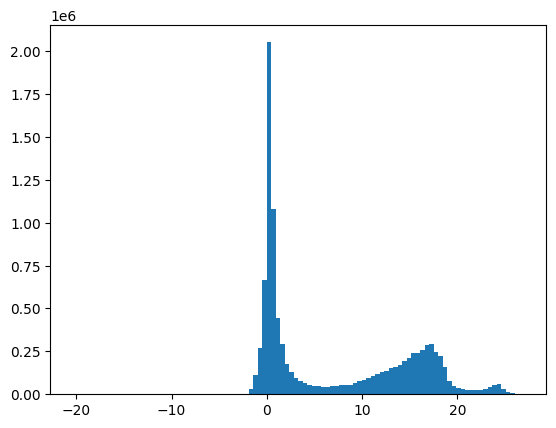

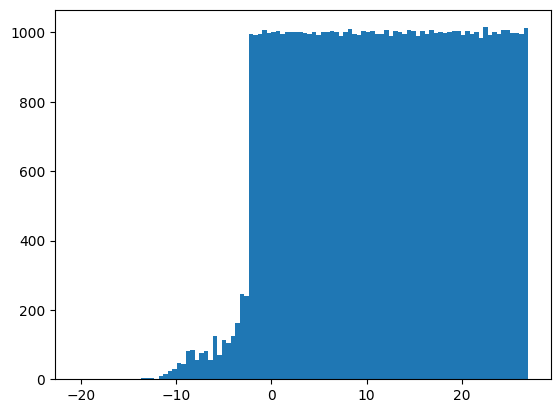

In [303]:
N_bins = 100 
z_data = df_map['z'].values  
N_map_points = 100_000 
N_points_per_bin = N_map_points // N_bins 

# plot distribution of z 
plt.figure()
plt.hist(z_data, bins=N_bins) 
# plt.ylim([0, 1E5])

# compute bin edges 
bin_edges = np.linspace(min(z_data), max(z_data), N_bins+1) 
idx_sample = [] 

for i in range(N_bins): 
    bin_min = bin_edges[i] 
    bin_max = bin_edges[i+1] 
    idx = np.where((z_data >= bin_min) & (z_data < bin_max))[0] 
    idx_bin_sample = np.random.choice(idx, min(N_points_per_bin,len(idx)), replace=False) 
    idx_sample.extend(idx_bin_sample) 

df_map_z_sampled = df_map.iloc[idx_sample]  

plt.figure()
plt.hist(df_map_z_sampled['z'], bins=N_bins) 

Guess Number: 0, Num Iterations: 128, Final Residual: 5.936854962192922e-16, Initial MAE: 1.59, Final MAE: 0.60
Guess Number: 1, Num Iterations: 91, Final Residual: 6.195554527577805e-16, Initial MAE: 3.00, Final MAE: 0.61
Guess Number: 2, Num Iterations: 149, Final Residual: 6.354317433749042e-16, Initial MAE: 1.67, Final MAE: 0.65
Guess Number: 3, Num Iterations: 142, Final Residual: 6.401567338785276e-16, Initial MAE: 2.74, Final MAE: 0.60
Guess Number: 4, Num Iterations: 111, Final Residual: 6.061397587311386e-16, Initial MAE: 2.20, Final MAE: 0.61
Guess Number: 5, Num Iterations: 86, Final Residual: 6.123727453507201e-16, Initial MAE: 3.41, Final MAE: 0.57
Guess Number: 6, Num Iterations: 134, Final Residual: 6.786523902976144e-16, Initial MAE: 1.58, Final MAE: 0.57
Guess Number: 7, Num Iterations: 69, Final Residual: 6.181743548509436e-16, Initial MAE: 2.42, Final MAE: 0.60
Guess Number: 8, Num Iterations: 98, Final Residual: 6.699578471918693e-16, Initial MAE: 1.44, Final MAE: 0

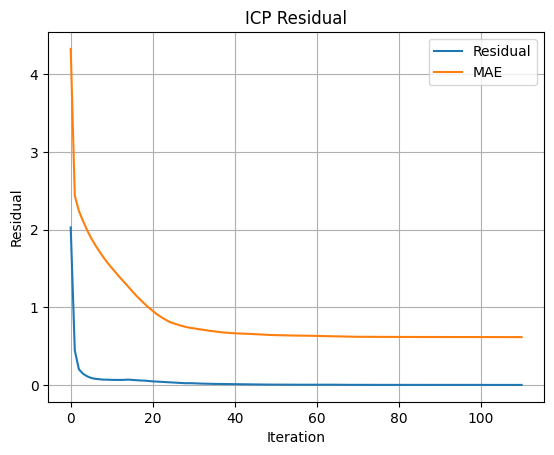

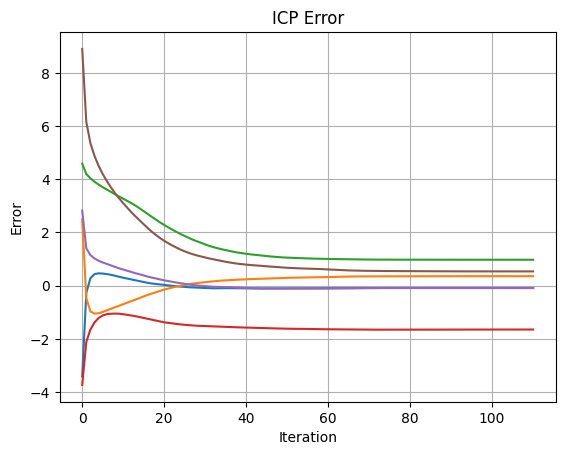

In [305]:
# TODO: refactor into a function 
# TODO: save data from all guesses to make a monte carlo plot of errors 
# TODO: determine if the best estimate can be determined from the lowest residual - plot residual vs error - plot values for initial and final iterations 
# TODO: automate for all trials 

trial_num = np.random.randint(0, N_trials)  
N_guesses = 10 
N_points_map = 100_000 
N_points_obs = 1000

flag_obs_from_mujoco = True 
flag_noisy_obs = True     
flag_downsample_obs = False     
flag_uniform_z_sample_map = False    
flag_iteration_output = False 
flag_guess_output = True 

for j in range(N_guesses): 
    lowest_res = float('inf') 

    if flag_obs_from_mujoco: 
        if flag_uniform_z_sample_map: 
            # use map from mujoco and randomly downsample 
            map = df_map_z_sampled[pose_indices].values
        else: 
            # use map from mujoco and randomly downsample 
            map = df_map[pose_indices].values 
            map = map[np.random.choice(map.shape[0], N_points_map, replace=False)] 
    else: 
        # use map from trial 
        map = contact_poses_list[trial_num][pose_indices].values 

    # use observation from trial 
    observation = contact_delta_poses_list[trial_num][pose_indices].values 
    if flag_downsample_obs: 
        observation = observation[np.random.choice(observation.shape[0], min(N_points_obs,len(observation)), replace=False)] 

    T_R_S = trials_pose_0_list[trial_num]  
    T_S_R = invert_pose6D(T_R_S)

    # add noise to observation 
    if flag_noisy_obs: 
        observation = observation + np.random.normal(0, 1.0, observation.shape) 

    # define map and kd-tree 
    T_R_t = map 
    T_t_R = invert_pose6D(T_R_t) 
    kdtree = KDTree(T_R_t) 

    # define offset and transform map by offset to define observation 
    T_S_t = observation 

    # add noise to true offset to define initial guess 
    T_r_R = np.random.normal(0, 3.0, 6) 
    T_r_S0 = apply_delta_pose(T_r_R, T_R_S) 
    T_r_S = T_r_S0 
    T_r_t0 = apply_delta_pose(T_r_S0, T_S_t) # T_r_t = T_r_S @ T_S_t # undo the observations by the initial guess 
    T_r_t = T_r_t0 

    max_iter = 250   
    res = np.zeros(max_iter) + float('inf') 
    err = np.zeros((max_iter, 6)) + float('inf') 

    for i in range(max_iter):

        # find nearest neighbors 
        dist, idx = kdtree.query(T_r_t) # match T_r_t to T_R_t 
        T_R_t_correspondences = T_R_t[idx] 

        # compute residual 
        T_t_r = invert_pose6D(T_r_t) 
        T_R_r = apply_delta_pose(T_R_t_correspondences, T_t_r) 
        T_R_r_mean = np.mean(T_R_r, axis=0) 
        res[i] = np.mean(np.abs(T_R_r_mean)) 

        # compute true error 
        err[i,:] = compute_delta_pose(T_r_S, T_R_S) 

        if flag_iteration_output: 
            # output progress every 10% of iterations 
            if (i+1) % max(np.floor(max_iter/10),1) == 0 or i==0: 
                print(f"Completion Progress: {i}/{max_iter}, Residual: {res[i]}, MAE: {np.mean(np.abs(err[i]))}") 

        if res[i] < 1e-18 or abs(res[i] - res[i-1]) < 1e-18: 
            if flag_iteration_output: 
                print(f"Terminating at iteration {i} with residual {res[i]}.\n")  
            break

        # update estimate 
        T_r_t = apply_delta_pose(T_R_r_mean, T_r_t)
        T_r_S = apply_delta_pose(T_R_r_mean, T_r_S)  

    if res[i] < lowest_res: 
        lowest_res = res[i] 
        best_initial_guess = T_r_S0 
        best_estimate = T_r_S 
        best_res = res 
        best_err = err 

    if flag_guess_output: 
        print(f"Guess Number: {j}, Num Iterations: {i}, Final Residual: {lowest_res}, Initial MAE: {np.mean(np.abs(compute_delta_pose(T_r_S0, T_R_S))):.2f}, Final MAE: {np.mean(np.abs(compute_delta_pose(T_r_S, T_R_S))):.2f}") 

error_initial = compute_delta_pose(best_initial_guess, T_R_S) 
error_final = compute_delta_pose(best_estimate, T_R_S) 
print("Initial Error: ", error_initial)
print("Final Error: ", error_final) 
print("\n")

if flag_downsample_obs: 
    print("Num Points in Map: ", N_points_map) 
    print("Num Points in Observation: ", N_points_obs) 

# plot residual and MAE  
# plt.plot(res) 
# plt.plot(np.mean(np.abs(err), axis=1)) 
plt.plot(best_res) 
plt.plot(np.mean(np.abs(best_err), axis=1)) 
plt.legend(["Residual", "MAE"]) 
plt.xlabel("Iteration")
plt.ylabel("Residual") 
plt.title("ICP Residual")
plt.grid(True)
plt.show()

# plot error 
plt.plot(best_err) 
plt.xlabel("Iteration") 
plt.ylabel("Error") 
plt.title("ICP Error") 
plt.grid(True) 
plt.show() 

